<a href="https://colab.research.google.com/github/jaehyun0220/Colab/blob/master/SDS_PublicData_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3조. 건강검진 데이터를 활용한 치아우식증 발생 예측
#### # Ver 6. Keras 활용 MLP

In [188]:
# Auth 인증 및 Google Drive 활용 Data load
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


#### #2. 작업환경 세팅

In [189]:
# woe package install
! pip install woe

In [0]:
# 기본 라이브러리 로드
import pandas as pd
import numpy as np
import os, sys

from tqdm import tqdm_notebook

import re
import tensorflow as tf

#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit

#모델 알고리즘 로드
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

#차원축소 알고리즘 로드
from sklearn.decomposition import PCA

# Calculate IV Setting
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import string
import woe
from woe.eval import plot_ks

# Deep Learning Model 로드
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier

from keras import optimizers

from keras.callbacks import TensorBoard

# Pytorch 로드
import torch
import torch.nn as nn # for neural net # nn: Deep learning model에 필요한 모듈이 모아져 있는 패키지 ex) nn.Linear(128, 128), nn.ReLU()
import torch.nn.functional as F # F: nn과 같은 모듈이 모아져 있지만 함수의 input으로 반드시 연산이 되어야 하는 값을 받습니다. ex) F.linear(X, 128, 128), R.relu(X)
import torch.optim as optim # 학습에 관련된 optimizing method가 있는 패키지
import torch.utils.data as data_utils # batch generator 등 학습 데이터에 관련된 패키지

#HyperParameter Tuning을 위한 라이브러리 로드
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#모델 평가를 위한 라이브러리 로드
from sklearn import metrics, model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter
import math

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import seaborn as sns
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

#### #3.사용할 사용자 함수 정의

In [0]:
def auc_graph(roc_auc, fpr, tpr):
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

# Define a binning function for continous independent variables
max_bin = 20
force_bin = 3

def mono_bin(Y, X, n = max_bin):
  df1 = pd.DataFrame({"X": X, "Y": Y})
  justmiss = df1[['X','Y']][df1.X.isnull()]
  notmiss = df1[['X','Y']][df1.X.notnull()]
  r = 0
  while np.abs(r) < 1:
    try:
      global d1
      global d2
      d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
      d2 = d1.groupby('Bucket', as_index=True)
      r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
      n = n - 1 
    except Exception as e:
      n = n - 1
      break
      
  if len(d2) == 1:
    n = force_bin         
    bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
    if len(np.unique(bins)) == 2:
        bins = np.insert(bins, 0, 1)
        bins[1] = bins[1]-(bins[1]/2)
    d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
    d2 = d1.groupby('Bucket', as_index=True)

  d3 = pd.DataFrame({},index=[])
  d3["MIN_VALUE"] = d2.min().X
  d3["MAX_VALUE"] = d2.max().X
  d3["COUNT"] = d2.count().Y
  d3["EVENT"] = d2.sum().Y
  d3["NONEVENT"] = d2.count().Y - d2.sum().Y
  d3=d3.reset_index(drop=True)

  if len(justmiss.index) > 0:
      d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
      d4["MAX_VALUE"] = np.nan
      d4["COUNT"] = justmiss.count().Y
      d4["EVENT"] = justmiss.sum().Y
      d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
      d3 = d3.append(d4,ignore_index=True)

  d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
  d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["VAR_NAME"] = "VAR"
  d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
  d3 = d3.replace([np.inf, -np.inf], 0)
  d3.IV = d3.IV.sum()

  return(d3)
  
# Define a binning function for categorical independent variables
def char_bin(Y, X):
  df1 = pd.DataFrame({"X": X, "Y": Y})
  justmiss = df1[['X','Y']][df1.X.isnull()]
  notmiss = df1[['X','Y']][df1.X.notnull()]    
  df2 = notmiss.groupby('X',as_index=True)

  d3 = pd.DataFrame({},index=[])
  d3["COUNT"] = df2.count().Y
  d3["MIN_VALUE"] = df2.sum().Y.index
  d3["MAX_VALUE"] = d3["MIN_VALUE"]
  d3["EVENT"] = df2.sum().Y
  d3["NONEVENT"] = df2.count().Y - df2.sum().Y

  if len(justmiss.index) > 0:
    d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
    d4["MAX_VALUE"] = np.nan
    d4["COUNT"] = justmiss.count().Y
    d4["EVENT"] = justmiss.sum().Y
    d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
    d3 = d3.append(d4,ignore_index=True)

  d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
  d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["VAR_NAME"] = "VAR"
  d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
  d3 = d3.replace([np.inf, -np.inf], 0)
  d3.IV = d3.IV.sum()
  d3 = d3.reset_index(drop=True)

  return(d3)

# Calculate Information Values
def calc_iv_all(df1, target):
    
  stack = traceback.extract_stack()
  filename, lineno, function_name, code = stack[-2]
  vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
  final = (re.findall(r"[\w']+", vars_name))[-1]

  x = df1.dtypes.index
  count = -1

  for i in tqdm_notebook(x):
    if i.upper() not in (final.upper()):
      if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
        conv = mono_bin(target, df1[i])
        conv["VAR_NAME"] = i
        count = count + 1
      else:
        conv = char_bin(target, df1[i])
        conv["VAR_NAME"] = i            
        count = count + 1

      if count == 0:
        iv_df = conv
      else:
        iv_df = iv_df.append(conv,ignore_index=True)

  iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
  iv = iv.reset_index()
  return(iv_df,iv)

##### #3-1. Keras를 위한 평가 함수 정의

In [0]:
# Deep Learning 평가를 위한 평가 함수 정의
from keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

#### #4.원천 데이터 load 및 seed 설정

In [193]:
set_random_seed = 2580 # seed 지정
target_nm = 'dental_carries' # 타겟 변수 지정

#### 2013년 기준 #########################################################################################################################################
df_raw_2013 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2013_eng.csv', encoding = 'euc-kr')

# 컬럼명 내 불필요한 공백 및 특수문자 제거
df_raw_2013.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

# 구강검진 결과가 있는 데이터셋만 load
df_data = df_raw_2013[df_raw_2013['examine_mouth']==1]

# 분석과 관련 없는 변수 및 기타 점검이 어려운 치아 관련 변수 삭제 
del_cols = ['baseyear', 'id', 'data_open_date','examine_mouth']
df_data.drop(columns=del_cols, axis=1, inplace=True)

# 치아우식증 결과가 있는 데이터만 끌고 옴
df_data = df_data[~(df_data['dental_carries'].isnull()) & (df_data['dental_carries'] != 2)]

# null 포함 데이터 모두 삭제 
df_data.dropna(how='any', inplace=True)
display(df_data.info())
print(len(df_data))

print(df_data[target_nm].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380657 entries, 3 to 999998
Data columns (total 30 columns):
sex                      380657 non-null int64
ageband                  380657 non-null int64
province                 380657 non-null int64
height                   380657 non-null int64
weight                   380657 non-null int64
waist                    380657 non-null int64
sight_l                  380657 non-null float64
sight_r                  380657 non-null float64
hearing_l                380657 non-null float64
hearing_r                380657 non-null float64
bp_systolic              380657 non-null int64
bp_diastolic             380657 non-null int64
bs_before                380657 non-null int64
tot_cholesterol          380657 non-null int64
triglycerides            380657 non-null int64
HDL_cholesterol          380657 non-null int64
LDL_cholesterol          380657 non-null float64
hemoglobin               380657 non-null float64
piu                      380657

None

380657
0.0    288017
1.0     92640
Name: dental_carries, dtype: int64


#### #5. 데이터샘플링 및 Wrangling

In [194]:
df_sample = df_data.copy()
print(df_sample[target_nm].value_counts())

0.0    288017
1.0     92640
Name: dental_carries, dtype: int64


In [0]:
# 명목형 변수 변경
category_features = ['sex', 'ageband', 'height', 'weight','province', 'hearing_l', 'hearing_r', 'smoking','drinking', 'piu', 'missing_tooth', 'dental_abrasion', 'wisdom_teeth_abnormal', 'plaque']

for col in df_data.columns:
  if col in category_features:
    df_sample[col] = df_sample[col].astype(object)

##### #5-1.내부 명목형 변수 묶기

In [0]:
# 명목형 변수의 범주화
# 성별코드 변환
df_sample["C_sex"] = df_sample["sex"].apply(lambda x:  'Male' if x == 1 else 'Female')

# 연령대코드 5세 단위 변환
min_age_code = df_sample["ageband"].min()

df_sample["C_ageband"] = df_sample["ageband"].apply(lambda x:  (x-1)*5 + 20 if min_age_code == 1 else (x-1)*5).astype(object)

# 시도코드 변환
df_sample["C_province"] = np.where(df_sample['province'] == 11, 'Seoul', 
                            np.where(df_sample['province']== 26, 'Busan', 
                              np.where(df_sample['province'] == 27, 'Daegu', 
                                np.where(df_sample['province'] == 28, 'Incheon', 
                                  np.where(df_sample['province'] == 29, 'Kwangju', 
                                    np.where(df_sample['province'] == 30, 'Daejeon', 
                                      np.where(df_sample['province'] == 31, 'Ulsan', 
                                        np.where(df_sample['province'] == 36, 'Sejong', 
                                          np.where(df_sample['province'] == 41, 'Gyeonggi', 
                                            np.where(df_sample['province'] == 42, 'Gangwon', 
                                              np.where(df_sample['province'] == 43, 'Chungbuk', 
                                                np.where(df_sample['province'] == 44, 'Chungnam', 
                                                  np.where(df_sample['province'] == 45, 'Jeonbuk', 
                                                    np.where(df_sample['province'] == 46, 'Jeonnam', 
                                                      np.where(df_sample['province'] == 47, 'Gyungbuk', 
                                                        np.where(df_sample['province'] == 48, 'Gyungnam', 
                                                          np.where(df_sample['province'] == 49, 'Jeju', 'Err')
                                      ))))))))))))))))

# 청력좌  변환
df_sample["C_hearing_l"] = df_sample["hearing_l"].apply(lambda x:  'Normal' if x == 1 else 'Abnormal')

# 청력우  변환
df_sample["C_hearing_r"] = df_sample["hearing_r"].apply(lambda x:  'Normal' if x == 1 else 'Abnormal')

# 요단백  변환
df_sample["C_piu"] = df_sample["piu"].apply(lambda x:  'Negative' if x == 1 else 'Positive')

# 흡연상태  변환
df_sample["C_smoking"] = df_sample["smoking"].apply(lambda x:  'NonSmoking' if x == 1 else ('StopSmoking' if x==2 else 'Smoking'))

# 음주여부  변환
df_sample["C_drinking"] = df_sample["drinking"].apply(lambda x:  'NonDrinking' if x == 0 else 'Drinking')

# 결손치 여부  변환
df_sample["C_missing_tooth"] = df_sample["missing_tooth"].apply(lambda x:  'Normal' if x == 0 else 'Abnormal')

# 치석 여부  변환
df_sample["C_dental_abrasion"] = df_sample["dental_abrasion"].apply(lambda x:  'Normal' if x == 0 else 'Abnormal')

# 치석 여부  변환
df_sample["C_wisdom_teeth_abnormal"] = df_sample["wisdom_teeth_abnormal"].apply(lambda x:  'Normal' if x == 0 else 'Abnormal')

# 치석 여부  변환
df_sample["C_plaque"] = df_sample["plaque"].apply(lambda x:  'Normal' if x == 0 else 'Abnormal')

# 변환 명목형 원 컬럼 삭제
del_obj_trans_cols = ['sex', 'ageband', 'province', 'hearing_l', 'hearing_r', 'piu', 'smoking', 'drinking', 'missing_tooth', 'dental_abrasion', 'wisdom_teeth_abnormal', 'plaque']
df_sample.drop(columns=del_obj_trans_cols, axis=1, inplace=True)

##### #5-3. 내부 수치형 변수 정규화

In [0]:
# 수치형 변수들 중 분포 이슈로 log 값을 취할 필요 있는 변수들 추출
num_ln_target_features = ['sight_l', 'sight_r', 'AST','ALT', 'bs_before','serum_creatinine','GammaGTP','tot_cholesterol', 'triglycerides']

# Feature Engineering의 일환으로 Log 값 취한 뒤 Normalization을 하여 변수명 + LN (lognorm)으로 열 추가 후 그래프 다시 그림
num_ln_cols = list(map(lambda x: "LN_"+str(x), num_ln_target_features))

num_pipeline = Pipeline([
        ('log_scaler', FunctionTransformer(np.log1p, validate=True)), # pipeline 내 log transformation을 위해 Function Transfomer 사용
        ('normalizer', MinMaxScaler()),
    ])

piped_np = num_pipeline.fit_transform(df_sample[num_ln_target_features])
piped_df = pd.DataFrame(piped_np, columns=num_ln_cols)

piped_df.head()

df_sample.drop(columns=num_ln_target_features, axis=1, inplace=True)

In [198]:
print("Before Re-indexing: Data count is ", len(df_sample))
df_sample.drop_duplicates()
df_sample.reset_index(inplace=True, drop=True)
print("After Re-indexing: Data count is ", len(df_sample))

df_fe = pd.concat([df_sample, piped_df], axis=1)
df_fe.head()

Before Re-indexing: Data count is  380657
After Re-indexing: Data count is  380657


,height,weight,waist,bp_systolic,bp_diastolic,HDL_cholesterol,LDL_cholesterol,hemoglobin,dental_carries,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,C_missing_tooth,C_dental_abrasion,C_wisdom_teeth_abnormal,C_plaque,LN_sight_l,LN_sight_r,LN_AST,LN_ALT,LN_bs_before,LN_serum_creatinine,LN_GammaGTP,LN_tot_cholesterol,LN_triglycerides
0,145,40,62,110,70,87,110.0,12.4,1.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.260671,0.260671,0.324587,0.242257,0.273586,0.097408,0.393001,0.562271,0.524264
1,145,45,72,100,53,46,140.0,13.1,1.0,Female,20,Seoul,Normal,Normal,Negative,NonSmoking,Drinking,Normal,Normal,Normal,Abnormal,0.214731,0.037939,0.313473,0.301486,0.300466,0.110197,0.313119,0.560370,0.632675
2,145,60,81,119,79,55,1494.0,12.7,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.105152,0.214731,0.430787,0.469957,0.389152,0.083842,0.412729,0.578979,0.544586
3,150,40,61,132,88,83,33.0,13.7,0.0,Female,20,Gyungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Abnormal,0.214731,0.214731,0.353958,0.301486,0.328540,0.122296,0.258977,0.364558,0.511384
4,150,40,61,95,65,56,83.0,12.4,0.0,Female,20,Gyeonggi,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Abnormal,0.135235,0.135235,0.344750,0.362609,0.289235,0.083842,0.258977,0.438554,0.539037


#### #6. 외부변수 추가

In [199]:
df_add1 = pd.read_csv('../gdrive/My Drive/sds/data/DentalExamineResult_2014_PortionbyTotInspector.csv', encoding = 'euc-kr')
df_add2 = pd.read_csv('../gdrive/My Drive/sds/data/KOSIS_AgeSex_AverageDentalVisitCnt_2012.csv', encoding = 'euc-kr')
df_add3 = pd.read_csv('../gdrive/My Drive/sds/data/KOSIS_DentalPrevalenceTrend_2012.csv', encoding = 'euc-kr')
df_add4 = pd.read_csv('../gdrive/My Drive/sds/data/chs_12_final_from_python.csv', encoding = 'euc-kr')

# Multiple Key를 사용하여 Join
# left_on=['column_name1','column_name2'], right_on = ['column_name3','column_name4']
print(len(df_fe))

df_new = pd.merge(left=df_fe, right=df_add1, how='outer', left_on=['C_province','C_sex'], right_on = ['Province','Sex'], sort=False)
df_new.drop(columns=['Province','Sex'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

df_new = pd.merge(left=df_new, right=df_add2, how='outer', left_on=['C_ageband','C_sex'], right_on = ['Ageband','Sex'], sort=False)
df_new.drop(columns=['Ageband','Sex'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

df_new = pd.merge(left=df_new, right=df_add3, how='outer', left_on=['C_ageband','C_sex'], right_on = ['Ageband','Sex'], sort=False)
df_new.drop(columns=['Ageband','Sex'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

df_new = pd.merge(left=df_new, right=df_add4, how='left', left_on=['C_ageband','C_sex','C_province', 'weight', 'height'], right_on = ['R_ageband','R_sex','R_province','R_weight','R_height'], sort=False)
df_new.drop(columns=['R_ageband','R_sex','R_province','R_weight','R_height'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

display(df_new.info())

380657


,height,weight,waist,bp_systolic,bp_diastolic,HDL_cholesterol,LDL_cholesterol,hemoglobin,dental_carries,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,C_missing_tooth,C_dental_abrasion,C_wisdom_teeth_abnormal,C_plaque,LN_sight_l,LN_sight_r,LN_AST,LN_ALT,LN_bs_before,LN_serum_creatinine,LN_GammaGTP,LN_tot_cholesterol,LN_triglycerides,A_NormalA_Result,A_NormalB_Result,A_Caution_Result,A_NeedCare_Result,A_Nutrition_Edu,A_Hygine_Edu,A_Fluoride_Edu,A_Examine_Rec,A_Care_Rec,A_Carries_Rec,A_Cure_Rec
0,145,40,62,110,70,87,110.0,12.4,1.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.260671,0.260671,0.324587,0.242257,0.273586,0.097408,0.393001,0.562271,0.524264,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09
1,145,60,81,119,79,55,1494.0,12.7,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.105152,0.214731,0.430787,0.469957,0.389152,0.083842,0.412729,0.578979,0.544586,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09
2,150,40,74,100,60,62,75.0,13.3,0.0,Female,20,Chungbuk,Normal,Normal,Negative,Smoking,Drinking,Normal,Normal,Normal,Abnormal,0.214731,0.214731,0.362668,0.288594,0.311299,0.069401,0.385848,0.428035,0.521140,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09
3,150,45,78,125,70,65,74.0,14.5,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,Drinking,Normal,Normal,Normal,Normal,0.238306,0.189809,0.370931,0.274579,0.325169,0.083842,0.242023,0.443710,0.572095,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09
4,150,50,81,118,70,60,135.0,13.3,0.0,Female,20,Chungbuk,Normal,Normal,Positive,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.214731,0.260671,0.386285,0.274579,0.321760,0.110197,0.334605,0.552673,0.504536,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09


380657


,height,weight,waist,bp_systolic,bp_diastolic,HDL_cholesterol,LDL_cholesterol,hemoglobin,dental_carries,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,C_missing_tooth,C_dental_abrasion,C_wisdom_teeth_abnormal,C_plaque,LN_sight_l,LN_sight_r,LN_AST,LN_ALT,LN_bs_before,LN_serum_creatinine,LN_GammaGTP,LN_tot_cholesterol,LN_triglycerides,A_NormalA_Result,A_NormalB_Result,A_Caution_Result,A_NeedCare_Result,A_Nutrition_Edu,A_Hygine_Edu,A_Fluoride_Edu,A_Examine_Rec,A_Care_Rec,A_Carries_Rec,A_Cure_Rec,A_AverageDentalHospitalVisitCnt,A_AverageDentalClinicVisitCnt
0,145,40,62,110,70,87,110.0,12.4,1.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.260671,0.260671,0.324587,0.242257,0.273586,0.097408,0.393001,0.562271,0.524264,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57
1,145,60,81,119,79,55,1494.0,12.7,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.105152,0.214731,0.430787,0.469957,0.389152,0.083842,0.412729,0.578979,0.544586,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57
2,150,40,74,100,60,62,75.0,13.3,0.0,Female,20,Chungbuk,Normal,Normal,Negative,Smoking,Drinking,Normal,Normal,Normal,Abnormal,0.214731,0.214731,0.362668,0.288594,0.311299,0.069401,0.385848,0.428035,0.521140,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57
3,150,45,78,125,70,65,74.0,14.5,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,Drinking,Normal,Normal,Normal,Normal,0.238306,0.189809,0.370931,0.274579,0.325169,0.083842,0.242023,0.443710,0.572095,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57
4,150,50,81,118,70,60,135.0,13.3,0.0,Female,20,Chungbuk,Normal,Normal,Positive,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.214731,0.260671,0.386285,0.274579,0.321760,0.110197,0.334605,0.552673,0.504536,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57


380657


,height,weight,waist,bp_systolic,bp_diastolic,HDL_cholesterol,LDL_cholesterol,hemoglobin,dental_carries,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,C_missing_tooth,C_dental_abrasion,C_wisdom_teeth_abnormal,C_plaque,LN_sight_l,LN_sight_r,LN_AST,LN_ALT,LN_bs_before,LN_serum_creatinine,LN_GammaGTP,LN_tot_cholesterol,LN_triglycerides,A_NormalA_Result,A_NormalB_Result,A_Caution_Result,A_NeedCare_Result,A_Nutrition_Edu,A_Hygine_Edu,A_Fluoride_Edu,A_Examine_Rec,A_Care_Rec,A_Carries_Rec,A_Cure_Rec,A_AverageDentalHospitalVisitCnt,A_AverageDentalClinicVisitCnt,A_DentalPrevalenceTrend
0,145,40,62,110,70,87,110.0,12.4,1.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.260671,0.260671,0.324587,0.242257,0.273586,0.097408,0.393001,0.562271,0.524264,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57,382
1,145,60,81,119,79,55,1494.0,12.7,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.105152,0.214731,0.430787,0.469957,0.389152,0.083842,0.412729,0.578979,0.544586,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57,382
2,150,40,74,100,60,62,75.0,13.3,0.0,Female,20,Chungbuk,Normal,Normal,Negative,Smoking,Drinking,Normal,Normal,Normal,Abnormal,0.214731,0.214731,0.362668,0.288594,0.311299,0.069401,0.385848,0.428035,0.521140,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57,382
3,150,45,78,125,70,65,74.0,14.5,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,Drinking,Normal,Normal,Normal,Normal,0.238306,0.189809,0.370931,0.274579,0.325169,0.083842,0.242023,0.443710,0.572095,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57,382
4,150,50,81,118,70,60,135.0,13.3,0.0,Female,20,Chungbuk,Normal,Normal,Positive,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.214731,0.260671,0.386285,0.274579,0.321760,0.110197,0.334605,0.552673,0.504536,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57,382


380657


,height,weight,waist,bp_systolic,bp_diastolic,HDL_cholesterol,LDL_cholesterol,hemoglobin,dental_carries,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,C_missing_tooth,C_dental_abrasion,C_wisdom_teeth_abnormal,C_plaque,LN_sight_l,LN_sight_r,LN_AST,LN_ALT,LN_bs_before,LN_serum_creatinine,LN_GammaGTP,LN_tot_cholesterol,LN_triglycerides,A_NormalA_Result,A_NormalB_Result,A_Caution_Result,A_NeedCare_Result,A_Nutrition_Edu,A_Hygine_Edu,A_Fluoride_Edu,A_Examine_Rec,A_Care_Rec,A_Carries_Rec,...,R_income,R_AnemiaDiag,R_AnginaPectorisDiag,R_ArthritisDiag,R_Asthma_Diag,R_MasticationLesion,R_BHepatitisDiag,R_CHepatitisDiag,R_HemorrhoidsDiag,R_HealthInstExp,R_HBP_Diag,R_PronounceLesion,R_DentureUse,R_SubjHealthLevel,R_EQVAS,R_FinEduGrade,R_DentDidNotExp,R_EQ5DNormLife,R_CPRRecognition,R_DrinkStartAge,R_FamilyCnt,R_AveSleepTime,R_AIDSRecognition,R_BPCheckinYear,R_WalkingDay,R_WalkingMinutes,R_SmokingStartAge,R_NutriChk,R_DrinkFreq,R_NearGYM,R_EQ5DPain,R_EQ5DAthleticAbility,R_BPCheckinYear.1,R_StressIndex,R_ExerciseMidHour,R_DrinkPerOnce,R_BreakfastperWeek,R_EQ5DSelfManage,R_ExerciseHighHour,target
0,145,40,62,110,70,87,110.0,12.4,1.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.260671,0.260671,0.324587,0.242257,0.273586,0.097408,0.393001,0.562271,0.524264,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,...,3600.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,65.000000,6.000000,0.000000,0.000000,1.0,19.000000,5.000000,9.000000,1.000000,0.000000,3.000000,15.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,1.000000,1.000000,7.000000,0.0,0.000000,0.000000
1,145,60,81,119,79,55,1494.0,12.7,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.105152,0.214731,0.430787,0.469957,0.389152,0.083842,0.412729,0.578979,0.544586,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,150,40,74,100,60,62,75.0,13.3,0.0,Female,20,Chungbuk,Normal,Normal,Negative,Smoking,Drinking,Normal,Normal,Normal,Abnormal,0.214731,0.214731,0.362668,0.288594,0.311299,0.069401,0.385848,0.428035,0.521140,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,...,6320.000000,0.400000,0.0,0.0,0.0,0.2,0.2,0.0,0.000000,0.600000,0.0,0.0,0.2,0.200000,75.000000,5.400000,0.400000,0.000000,0.6,19.000000,3.200000,6.800000,0.800000,3.000000,5.000000,10.000000,0.0,0.200000,0.400000,0.800000,0.200000,0.0,0.600000,1.000000,0.400000,1.000000,4.600000,0.0,2.400000,0.400000
3,150,45,78,125,70,65,74.0,14.5,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,Drinking,Normal,Normal,Normal,Normal,0.238306,0.189809,0.370931,0.274579,0.325169,0.083842,0.242023,0.443710,0.572095,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,...,3155.555556,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.111111,0.0,0.0,0.0,0.222222,76.666667,6.444444,0.444444,0.111111,1.0,16.555556,3.111111,7.333333,0.888889,0.444444,3.333333,13.888889,0.0,0.444444,0.333333,0.777778,0.444444,0.0,0.333333,1.000000,0.000000,0.777778,3.555556,0.0,0.222222,0.222222
4,150,50,81,118,70,60,135.0,13.3,0.0,Female,20,Chungbuk,Normal,Normal,Positive,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.214731,0.260671,0.386285,0.274579,0.321760,0.110197,0.334605,0.552673,0.504536,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,...,4700.000000,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.0,0.0,0.0,0.500000,68.333333,6.500000,0.000000,0.000000,1.0,19.333333,4.500000,7.333333,1.000000,0.833333,5.500000,28.333333,0.0,0.666667,0.000000,1.000000,0.000000,0.0,0.166667,0.833333,0.333333,0.833333,3.500000,0.0,1.000000,0.000000


380657
<class 'pandas.core.frame.DataFrame'>
Int64Index: 380657 entries, 0 to 380656
Data columns (total 84 columns):
height                             380657 non-null object
weight                             380657 non-null object
waist                              380657 non-null int64
bp_systolic                        380657 non-null int64
bp_diastolic                       380657 non-null int64
HDL_cholesterol                    380657 non-null int64
LDL_cholesterol                    380657 non-null float64
hemoglobin                         380657 non-null float64
dental_carries                     380657 non-null float64
C_sex                              380657 non-null object
C_ageband                          380657 non-null object
C_province                         380657 non-null object
C_hearing_l                        380657 non-null object
C_hearing_r                        380657 non-null object
C_piu                              380657 non-null object
C_smoking    

None

#### #7. IV 계산을 통한 변수 선택(기존 IV 값은 산출시 마다 소폭 변동하여 데이터 정합성을 위해 기존 #5 파일의 IV값 사용)

In [0]:
# # IV 산출
# iv_df, IV_first = calc_iv_all(df_new,df_new[target_nm])

# # IV 값 내림차순 정렬
# IV_first.sort_values('IV',ascending=False)

# # IV_select_col = list(IV_first[IV_first['IV']>=0.001]['VAR_NAME'])
# IV_select_col = ['A_AverageDentalClinicVisitCnt','A_AverageDentalHospitalVisitCnt','A_Care_Rec','A_Carries_Rec','A_Caution_Result','A_Cure_Rec','A_DentalPrevalenceTrend','A_Examine_Rec','A_Fluoride_Edu','A_Hygine_Edu','A_NeedCare_Result','A_NormalA_Result','A_NormalB_Result','A_Nutrition_Edu','C_ageband','C_dental_abrasion','C_drinking','C_missing_tooth','C_plaque','C_province','C_sex','C_smoking','C_wisdom_teeth_abnormal','LDL_cholesterol','LN_AST','LN_GammaGTP','LN_sight_l','LN_sight_r','LN_tot_cholesterol','LN_triglycerides','R_AIDSRecognition','R_AveSleepTime','R_BPCheckinYear','R_BPCheckinYear.1','R_BreakfastperWeek','R_CPRRecognition','R_DentDidNotExp','R_DrinkFreq','R_DrinkPerOnce','R_DrinkStartAge','R_EQ5DAthleticAbility','R_EQ5DNormLife','R_EQ5DPain','R_EQ5DSelfManage','R_EQVAS','R_ExerciseHighHour','R_ExerciseMidHour','R_FamilyCnt','R_FinEduGrade','R_NearGYM','R_NutriChk','R_SmokingStartAge','R_StressIndex','R_WalkingDay','R_WalkingMinutes','height','hemoglobin','weight']
# display(IV_select_col)
# print(len(IV_select_col))

In [201]:
# 외부변수와 매칭이 되지 않는 항목은 버림
df_new.dropna(how='any', inplace=True)
print(df_new[target_nm].value_counts())

0.0    279141
1.0     89200
Name: dental_carries, dtype: int64


In [202]:
# 치아우식 0과 1의 값을 5만건씩 총 10만건 추출
df_new = df_new.groupby(target_nm).apply(lambda x: x.sample(n=50000, random_state=set_random_seed))
df_new.reset_index(drop=True, inplace=True)
print(df_new[target_nm].value_counts())

1.0    50000
0.0    50000
Name: dental_carries, dtype: int64


In [203]:
# 독립변수와 종속변수를 나눠 줌
data_x = df_new[df_new.columns.difference([target_nm])]
# data_x = df_new[IV_select_col]
data_y = df_new[target_nm].astype('float64')

# 데이터를 나눈 뒤 속성별로 컬럼을 분류
num_attribs = [col for col in data_x.columns if data_x[col].dtype in ['int64','float64']]
cat_attribs = [col for col in data_x.columns if data_x[col].dtype not in ['int64','float64']]

num_attribs = list(set(num_attribs) - set([target_nm]))

print("num_attribs: ", num_attribs)
print("cat_attribs: ", cat_attribs)

num_attribs:  ['R_AnginaPectorisDiag', 'R_SmokingStartAge', 'A_AverageDentalClinicVisitCnt', 'R_MasticationLesion', 'A_Carries_Rec', 'R_AnemiaDiag', 'LN_bs_before', 'R_HBP_Diag', 'A_AverageDentalHospitalVisitCnt', 'R_AIDSRecognition', 'R_SubjHealthLevel', 'R_ExerciseMidHour', 'A_Fluoride_Edu', 'R_Asthma_Diag', 'R_EQ5DPain', 'R_CPRRecognition', 'R_income', 'R_WalkingMinutes', 'R_BPCheckinYear', 'target', 'R_BPCheckinYear.1', 'R_HemorrhoidsDiag', 'LN_serum_creatinine', 'LN_tot_cholesterol', 'bp_systolic', 'A_NeedCare_Result', 'R_CHepatitisDiag', 'waist', 'A_Caution_Result', 'R_ArthritisDiag', 'R_WalkingDay', 'bp_diastolic', 'R_FamilyCnt', 'LN_triglycerides', 'R_EQ5DAthleticAbility', 'R_DrinkFreq', 'A_Examine_Rec', 'LN_AST', 'R_DrinkStartAge', 'R_DentDidNotExp', 'R_NearGYM', 'A_NormalB_Result', 'R_ExerciseHighHour', 'R_StressIndex', 'LN_sight_r', 'R_FinEduGrade', 'R_PronounceLesion', 'A_NormalA_Result', 'A_DentalPrevalenceTrend', 'LN_GammaGTP', 'R_BHepatitisDiag', 'A_Care_Rec', 'LN_ALT', 

In [0]:
# 수치형 변수 정규화 
num_pipeline = Pipeline([
        ('min_max_scaler', MinMaxScaler()),
    ])

# numpy 형식으로 전체 변경
full_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_attribs),
        ("cat_encoder", OneHotEncoder(sparse=False), cat_attribs),
    ])

data_x_piped = full_pipeline.fit_transform(data_x)

data_y_piped = data_y.values

In [0]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_x_piped, data_y_piped, test_size = 0.2, random_state = set_random_seed)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.2, random_state = set_random_seed)

In [240]:
graph0 = tf.Graph()
with graph0.as_default():
    # placeholder
    activation = "relu"
    optimizer = keras.optimizers.Adam()
    input_dim = train_x.shape[1]
    batch_size = 128
    epochs = 10
    # create model
    model = Sequential()

with tf.Session(graph=graph0) as sess:
  model = Sequential()
  # 첫 번째 Layer (Input layer)
  model.add(Dense(input_dim=input_dim, activation=activation, output_dim=256))
  # # 두 번째 Layer (Hidden layer 1)
  model.add(Dense(output_dim=256, activation=activation))
  # # 세 번째 Layer (Hidden layer 2)
  model.add(Dense(output_dim=256, activation=activation))
  # Dense Layer (Output layer)
  model.add(Dense(output_dim=1))
  model.add(Activation("sigmoid"))

  # Cost function 및 Optimizer 설정 # binary class 분류이므로 binary_crossentropy 사용 # Adam optimizer 사용
  model.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['accuracy', precision, recall, f1score])
  hist0 = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(val_x, val_y))

  model.save("model_keras_0.h5")

Train on 64000 samples, validate on 16000 samples
Epoch 1/10
64000/64000 [==============================] - 4s 57us/step - loss: 0.6402 - acc: 0.6329 - precision: 0.6430 - recall: 0.6229 - f1score: 0.6220 - val_loss: 0.6370 - val_acc: 0.6376 - val_precision: 0.6315 - val_recall: 0.6696 - val_f1score: 0.6484
Epoch 2/10
64000/64000 [==============================] - 3s 52us/step - loss: 0.6333 - acc: 0.6401 - precision: 0.6459 - recall: 0.6293 - f1score: 0.6333 - val_loss: 0.6360 - val_acc: 0.6392 - val_precision: 0.6382 - val_recall: 0.6534 - val_f1score: 0.6440
Epoch 3/10
64000/64000 [==============================] - 3s 52us/step - loss: 0.6317 - acc: 0.6415 - precision: 0.6467 - recall: 0.6328 - f1score: 0.6355 - val_loss: 0.6333 - val_acc: 0.6401 - val_precision: 0.6402 - val_recall: 0.6490 - val_f1score: 0.6429
Epoch 4/10
64000/64000 [==============================] - 3s 53us/step - loss: 0.6293 - acc: 0.6426 - precision: 0.6455 - recall: 0.6424 - f1score: 0.6400 - val_loss: 0.6352

Test loss: 0.6411194895267487
Test accuracy: 0.6333
Accuracy: 0.63330
Confusion Matrix: 
 [[6969 3111]
 [4223 5697]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.623     0.691     0.655     10080
         1.0      0.647     0.574     0.608      9920

    accuracy                          0.633     20000
   macro avg      0.635     0.633     0.632     20000
weighted avg      0.635     0.633     0.632     20000

roc_auc score is :  0.6328317012288787


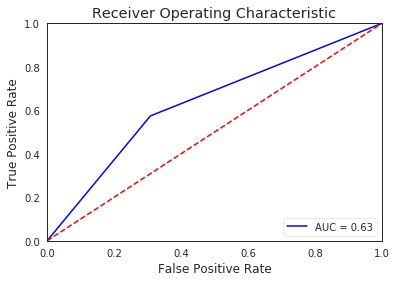

In [243]:
with tf.Session(graph=graph0) as sess:
  model_best = keras.models.load_model('model_keras_0.h5', custom_objects={'precision': precision, 'recall':recall, 'f1score':f1score})

  score = model_best.evaluate(test_x, test_y, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  pred_y_dl = model_best.predict(test_x)
  pred_y_dl = (pred_y_dl>0.5)
  print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_dl)))
  print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_dl))
  print("Classification Report Matrix: \n", classification_report(test_y, pred_y_dl, digits=3))

  roc_auc_dl1 = roc_auc_score(test_y, pred_y_dl)
  print("roc_auc score is : ", roc_auc_dl1)

  fpr, tpr, threshold = roc_curve(test_y, pred_y_dl)
  roc_auc = auc(fpr, tpr)

  auc_graph(roc_auc, fpr, tpr)

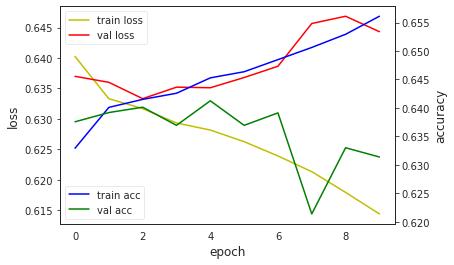

In [244]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist0.history['loss'], 'y', label='train loss')
loss_ax.plot(hist0.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist0.history['acc'], 'b', label='train acc')
acc_ax.plot(hist0.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.show()

In [228]:
graph1 = tf.Graph()
with graph1.as_default():
    # placeholder
    activation = "relu"
    optimizer = keras.optimizers.Adam()
    input_dim = train_x.shape[1]
    batch_size = 128
    epochs = 100
    # create model
    model = Sequential()

with tf.Session(graph=graph1) as sess:
  model = Sequential()
  # 첫 번째 Layer (Input layer)
  model.add(Dense(input_dim=input_dim, init='glorot_uniform', activation=activation, output_dim=256))
  model.add(Dropout(0.3)) # 30% 정도를 Drop 

  # # 두 번째 Layer (Hidden layer 1)
  model.add(Dense(output_dim=256, init='glorot_uniform', activation=activation))
  model.add(Dropout(0.3)) # 30% 정도를 Drop 

  # # 세 번째 Layer (Hidden layer 2)
  model.add(Dense(output_dim=256, init='glorot_uniform', activation=activation))
  model.add(Dropout(0.3)) # 30% 정도를 Drop 

  # Dense Layer (Output layer)
  model.add(Dense(output_dim=1))
  model.add(Activation("sigmoid"))

  # Cost function 및 Optimizer 설정 # binary class 분류이므로 binary_crossentropy 사용 # Adam optimizer 사용
  model.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['accuracy', precision, recall, f1score])

  callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5),
               keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                              monitor='val_loss',
                                              save_best_only=True)]

  hist1 = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(val_x, val_y), callbacks=callbacks)

Train on 64000 samples, validate on 16000 samples
Epoch 1/100
64000/64000 [==============================] - 4s 63us/step - loss: 0.6465 - acc: 0.6268 - precision: 0.6321 - recall: 0.6195 - f1score: 0.6195 - val_loss: 0.6409 - val_acc: 0.6375 - val_precision: 0.6638 - val_recall: 0.5633 - val_f1score: 0.6079
Epoch 2/100
64000/64000 [==============================] - 4s 59us/step - loss: 0.6377 - acc: 0.6374 - precision: 0.6417 - recall: 0.6322 - f1score: 0.6327 - val_loss: 0.6360 - val_acc: 0.6362 - val_precision: 0.6292 - val_recall: 0.6737 - val_f1score: 0.6490
Epoch 3/100
64000/64000 [==============================] - 4s 57us/step - loss: 0.6357 - acc: 0.6394 - precision: 0.6434 - recall: 0.6334 - f1score: 0.6346 - val_loss: 0.6357 - val_acc: 0.6408 - val_precision: 0.6654 - val_recall: 0.5736 - val_f1score: 0.6142
Epoch 4/100
64000/64000 [==============================] - 4s 58us/step - loss: 0.6349 - acc: 0.6397 - precision: 0.6437 - recall: 0.6335 - f1score: 0.6350 - val_loss: 0.

Test loss: 0.6319523021697998
Test accuracy: 0.6414
Accuracy: 0.64140
Confusion Matrix: 
 [[6093 3987]
 [3185 6735]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.657     0.604     0.630     10080
         1.0      0.628     0.679     0.653      9920

    accuracy                          0.641     20000
   macro avg      0.642     0.642     0.641     20000
weighted avg      0.643     0.641     0.641     20000

roc_auc score is :  0.6416978686635945


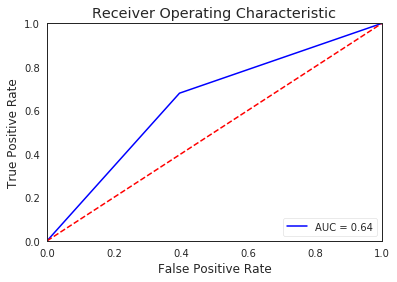

In [207]:
with tf.Session(graph=graph1) as sess:
  model_best = keras.models.load_model('best_model.h5', custom_objects={'precision': precision, 'recall':recall, 'f1score':f1score})

  score = model_best.evaluate(test_x, test_y, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  pred_y_dl = model_best.predict(test_x)
  pred_y_dl = (pred_y_dl>0.5)
  print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_dl)))
  print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_dl))
  print("Classification Report Matrix: \n", classification_report(test_y, pred_y_dl, digits=3))

  roc_auc_dl1 = roc_auc_score(test_y, pred_y_dl)
  print("roc_auc score is : ", roc_auc_dl1)

  fpr, tpr, threshold = roc_curve(test_y, pred_y_dl)
  roc_auc = auc(fpr, tpr)

  auc_graph(roc_auc, fpr, tpr)

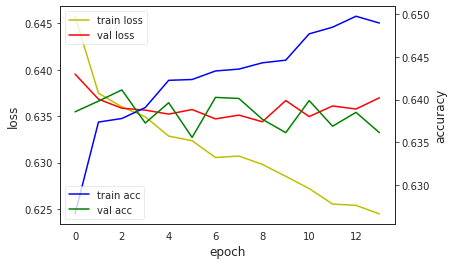

In [208]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist1.history['loss'], 'y', label='train loss')
loss_ax.plot(hist1.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist1.history['acc'], 'b', label='train acc')
acc_ax.plot(hist1.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.show()

In [235]:
graph2 = tf.Graph()
with graph2.as_default():
    # placeholder
    activation = keras.layers.LeakyReLU()
    optimizer = keras.optimizers.SGD()
    input_dim = train_x.shape[1]
    batch_size = 128
    epochs = 100
    # create model
    model = Sequential()

with tf.Session(graph=graph2) as sess:
  model = Sequential()
  # 첫 번째 Layer (Input layer)
  model.add(Dense(input_dim=input_dim, init='glorot_uniform', output_dim=256))
  model.add(BatchNormalization())
  model.add(activation)
  model.add(Dropout(0.3)) # 30% 정도를 Drop 

  # # 두 번째 Layer (Hidden layer 1)
  model.add(Dense(output_dim=256, init='glorot_uniform'))
  model.add(BatchNormalization())
  model.add(activation)
  model.add(Dropout(0.3)) # 30% 정도를 Drop 

  # # 세 번째 Layer (Hidden layer 2)
  model.add(Dense(output_dim=256, init='glorot_uniform'))
  model.add(BatchNormalization())
  model.add(activation)
  model.add(Dropout(0.3)) # 30% 정도를 Drop 

  # Dense Layer (Output layer)
  model.add(Dense(output_dim=1))
  model.add(Activation("sigmoid"))

  # Cost function 및 Optimizer 설정 # binary class 분류이므로 binary_crossentropy 사용 # Adam optimizer 사용
  model.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['accuracy', precision, recall, f1score])

  hist2 = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(val_x, val_y))

  model.save("model_keras_2.h5")

Train on 64000 samples, validate on 16000 samples
Epoch 1/100
64000/64000 [==============================] - 7s 105us/step - loss: 0.7077 - acc: 0.5813 - precision: 0.5826 - recall: 0.5781 - f1score: 0.5784 - val_loss: 0.6406 - val_acc: 0.6309 - val_precision: 0.6255 - val_recall: 0.6607 - val_f1score: 0.6411
Epoch 2/100
64000/64000 [==============================] - 6s 95us/step - loss: 0.6655 - acc: 0.6082 - precision: 0.6101 - recall: 0.6055 - f1score: 0.6061 - val_loss: 0.6386 - val_acc: 0.6358 - val_precision: 0.6359 - val_recall: 0.6417 - val_f1score: 0.6373
Epoch 3/100
64000/64000 [==============================] - 6s 95us/step - loss: 0.6548 - acc: 0.6161 - precision: 0.6189 - recall: 0.6109 - f1score: 0.6129 - val_loss: 0.6376 - val_acc: 0.6385 - val_precision: 0.6446 - val_recall: 0.6244 - val_f1score: 0.6328
Epoch 4/100
64000/64000 [==============================] - 6s 95us/step - loss: 0.6486 - acc: 0.6230 - precision: 0.6259 - recall: 0.6185 - f1score: 0.6202 - val_loss: 0

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               39168     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

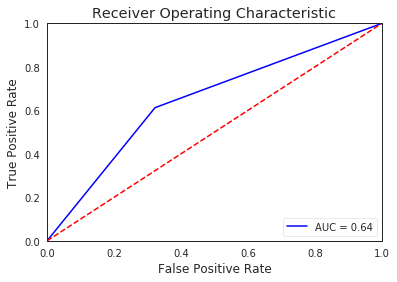

In [236]:
with tf.Session(graph=graph2) as sess:
  # load model
  model =  keras.models.load_model('model_keras_2.h5', custom_objects={'precision': precision, 'recall':recall, 'f1score':f1score})
  # summarize model.
  model.summary()

  score = model.evaluate(test_x, test_y, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  pred_y_dl = model.predict(test_x)
  pred_y_dl = (pred_y_dl>0.5)
  print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_dl)))
  print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_dl))
  print("Classification Report Matrix: \n", classification_report(test_y, pred_y_dl, digits=3))

  roc_auc_dl1 = roc_auc_score(test_y, pred_y_dl)
  print("roc_auc score is : ", roc_auc_dl1)

  fpr, tpr, threshold = roc_curve(test_y, pred_y_dl)
  roc_auc = auc(fpr, tpr)

  auc_graph(roc_auc, fpr, tpr)

# IV > 0001 Accuracy: 0.6444 F1score 0: 0.633 1: 0.655and IV > previous result 0.6435/0.639/ 0.648

# 0.64250 / 0.64440/ 0.6452

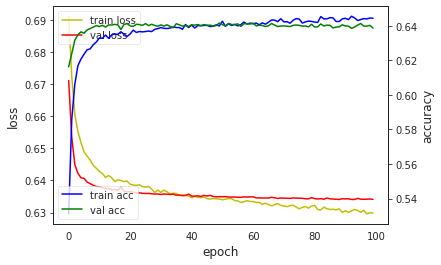

In [211]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist2.history['loss'], 'y', label='train loss')
loss_ax.plot(hist2.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist2.history['acc'], 'b', label='train acc')
acc_ax.plot(hist2.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.show()

In [237]:
graph3 = tf.Graph()
with graph3.as_default():
    # placeholder
    activation = "tanh"
    optimizer = keras.optimizers.SGD()
    input_dim = train_x.shape[1]
    batch_size = 128
    epochs = 50
    # create model
    model = Sequential()

with tf.Session(graph=graph3) as sess:
  model = Sequential()
  # 첫 번째 Layer (Input layer)
  model.add(Dense(input_dim=input_dim, init='glorot_uniform', output_dim=256))
  model.add(BatchNormalization())
  model.add(Activation(activation))
  model.add(Dropout(0.3)) # 30% 정도를 Drop 

  # # 두 번째 Layer (Hidden layer 1)
  model.add(Dense(output_dim=256, init='glorot_uniform'))
  model.add(BatchNormalization())
  model.add(Activation(activation))
  model.add(Dropout(0.3)) # 30% 정도를 Drop 

  # # 세 번째 Layer (Hidden layer 2)
  model.add(Dense(output_dim=256, init='glorot_uniform'))
  model.add(BatchNormalization())
  model.add(Activation(activation))
  model.add(Dropout(0.3)) # 30% 정도를 Drop 

  # Dense Layer (Output layer)
  model.add(Dense(output_dim=1))
  model.add(Activation("sigmoid"))

  # Cost function 및 Optimizer 설정 # binary class 분류이므로 binary_crossentropy 사용 # Adam optimizer 사용
  model.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['accuracy', precision, recall, f1score])

  hist3 = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(val_x, val_y))

  model.save("model_keras_3.h5")

Train on 64000 samples, validate on 16000 samples
Epoch 1/50
64000/64000 [==============================] - 7s 105us/step - loss: 0.6946 - acc: 0.5896 - precision: 0.5907 - recall: 0.5893 - f1score: 0.5882 - val_loss: 0.6412 - val_acc: 0.6339 - val_precision: 0.6372 - val_recall: 0.6301 - val_f1score: 0.6320
Epoch 2/50
64000/64000 [==============================] - 6s 97us/step - loss: 0.6613 - acc: 0.6136 - precision: 0.6150 - recall: 0.6120 - f1score: 0.6118 - val_loss: 0.6408 - val_acc: 0.6361 - val_precision: 0.6410 - val_recall: 0.6270 - val_f1score: 0.6323
Epoch 3/50
64000/64000 [==============================] - 6s 92us/step - loss: 0.6540 - acc: 0.6197 - precision: 0.6218 - recall: 0.6160 - f1score: 0.6171 - val_loss: 0.6403 - val_acc: 0.6362 - val_precision: 0.6405 - val_recall: 0.6309 - val_f1score: 0.6339
Epoch 4/50
64000/64000 [==============================] - 6s 97us/step - loss: 0.6470 - acc: 0.6257 - precision: 0.6273 - recall: 0.6242 - f1score: 0.6240 - val_loss: 0.638

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               39168     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)              

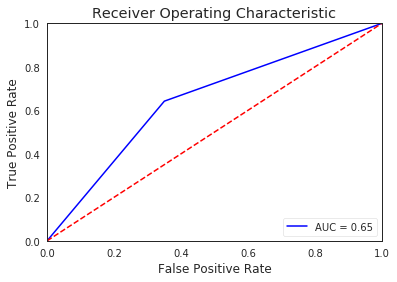

In [238]:
with tf.Session(graph=graph3) as sess:
  # load model
  model =  keras.models.load_model('model_keras_3.h5', custom_objects={'precision': precision, 'recall':recall, 'f1score':f1score})
  # summarize model.
  model.summary()

  score = model.evaluate(test_x, test_y, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  pred_y_dl = model.predict(test_x)
  pred_y_dl = (pred_y_dl>0.5)
  print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_dl))) # 0.6440 # 0.64500 with layer init
  print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_dl))
  print("Classification Report Matrix: \n", classification_report(test_y, pred_y_dl, digits=3))

  roc_auc_dl1 = roc_auc_score(test_y, pred_y_dl)
  print("roc_auc score is : ", roc_auc_dl1)

  fpr, tpr, threshold = roc_curve(test_y, pred_y_dl)
  roc_auc = auc(fpr, tpr)

  auc_graph(roc_auc, fpr, tpr)

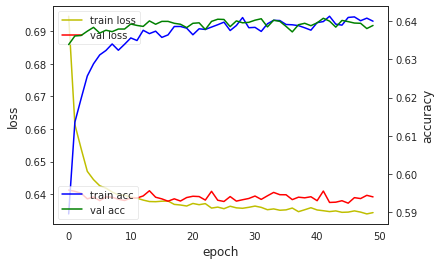

In [239]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist3.history['loss'], 'y', label='train loss')
loss_ax.plot(hist3.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist3.history['acc'], 'b', label='train acc')
acc_ax.plot(hist3.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.show()